# Стратегия взаимодействия с пользователями фитнес-центр
Проанализировать данные клиентов фитнес-центра:
 - научиться прогнозировать вероятность оттока
 - выделить несколько типичных групп пользователей
 - дать рекомендации по взаимодействию с клиентами

## <a id="contents" style="color:black">Содержание</a>

1. [Загрузка данных](#loading)
2. [Исследовательский анализ данных (EDA)](#eda)
    - [отсутствующие признаки, средние значения и стандартные отклонения;](#missing)
    - [средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался;](#mean)
    - [столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);](#dist)
    - [матрица корреляций.](#corr)
3. [Построение модели прогнозирования оттока пользователей](#churn_model)

4. [Кластеризация пользователей](#clastering)
    - [Матрица расстояний и дендрограмма](#linkage)
    - [K-Means](#k_means)
    - [Средние значения признаков кластеров](#clusters_means)
    - [Распределение признаков кластеров](clusters_dist)
    - [Доля оттока для каждого кластера](#churn_rate)
5. [Выводы и рекомендации](#results)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

## <a id="loading" style="color:black">1. Загрузка данных</a>

### Информация о данных:
Данные на месяц до оттока и факт оттока на определённый месяц  

`Churn` — факт оттока в текущем месяце;  

Данные пользователя за предыдущий до проверки факта оттока месяц:  
`gender` — пол  
`Near_Location` — проживание или работа в районе, где находится фитнес-центр  
`Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)  
`Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)  
`Phone` — наличие контактного телефона  
`Age` — возраст  
`Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах)

`Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)  
`Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах)  
`Group_visits` — факт посещения групповых занятий  
`Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента  
`Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц  
`Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон  


In [2]:
gym_churn = pd.read_csv('/datasets/gym_churn.csv')
gym_churn.head(10)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


## <a id="eda" style="color:black">2. Исследовательский анализ данных (EDA)</a>
[к содержанию](#contents)

### <a id="missing" style="color:black">2.1. отсутствующие признаки, средние значения и стандартные отклонения</a>

In [3]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

В таблице помимо целевой переменной 12 признаков, все значение заполнены, представлены числовыми типами.  

In [4]:
gym_churn.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Похоже посетители фитнес-центра примерно в равных частях распределены по полу.

In [5]:
gym_churn.query("gender == 0").shape[0]

1959

пол 0 - 1959 записей,  
пол 1 - 4000 - 1959 = 2041

Такая же ситуация и с распределением по признаку Partner (клиент компании-партнера или нет). Больше половины клиентов проживают или работают в районе, где находится фитнес-центр. Около трети из них зарегистрировались с помощью промокода от друга. Телефон оставили почти все клиенты. Групповые занятия посещают чуть меньше половины клиентов. В среднем возраст клиентов 29 лет +- 3 года. Около двух третей клиентов имеют пометку о том, что они "в оттоке".

Длительность абонемента -- больше чем у половины клиентов длительность текущего абонемента - 1 месяц. Меньше чем у четверти клиентов абонемент на 6 месяцев и на 12 месяцев.

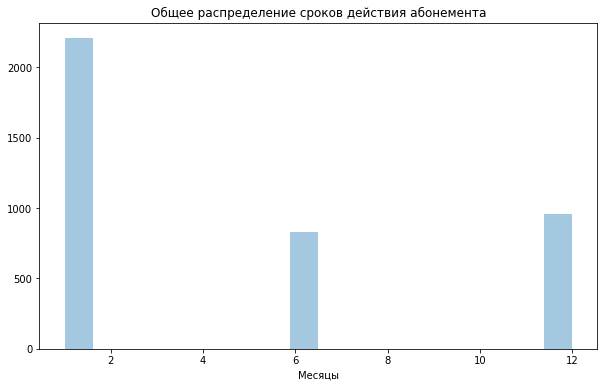

In [6]:
plt.figure(figsize=(10,6))
sns.distplot(gym_churn['Contract_period'], kde=False, axlabel='Месяцы')
plt.title('Общее распределение сроков действия абонемента');

Абонементами на 3 и 9 месяцев никто не пользуется. Соответственно срок до окончания текущего действующего абонемента имеет похожее распределение -- больше всего клиентов с оставшимся сроком 1 месяц.

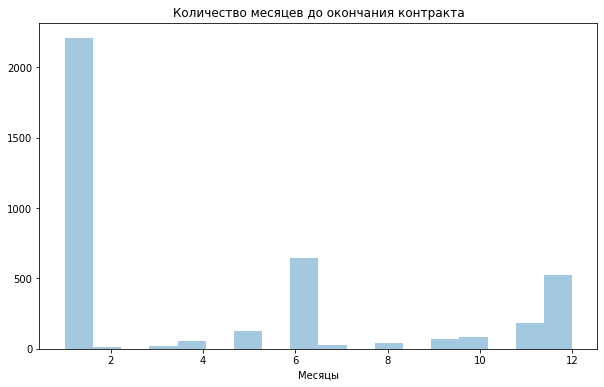

In [7]:
plt.figure(figsize=(10,6))
sns.distplot(gym_churn['Month_to_end_contract'], kde=False, axlabel='Месяцы')
plt.title('Количество месяцев до окончания абонемента');

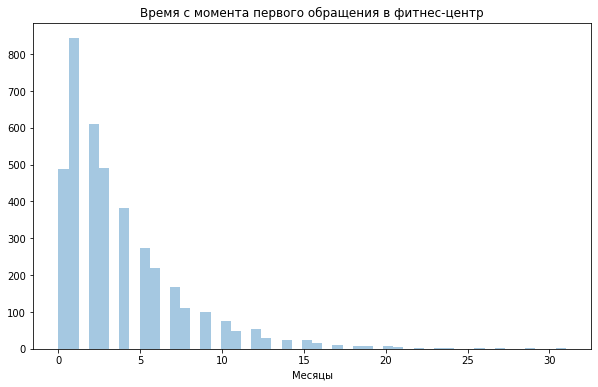

In [8]:
plt.figure(figsize=(10,6))
sns.distplot(gym_churn['Lifetime'], kde=False, axlabel='Месяцы')
plt.title('Время с момента первого обращения в фитнес-центр');

В среднем с момента первого обращение в фитнес-центр проходит 3 месяца. Примерно четверть клиентов с lifetime 5.  

Средняя частота посещений в неделю за все время с начала действия абонемента в среднем около двух раз, но нужно помнить, что у более чем половины клиентов текущий абонемент только на месяц, так что и средняя частота посещений в неделю за предыдущий месяц распределена примерно так же.

Средняя выручка от других услуг фитнес-центра за все время с начала действия абонемента в среднем у одного клиента около 136 денежных единиц

In [9]:
gym_churn.query("Churn == 1").shape[0]

1061

Клиентов в группе оттока в текущем месяце -- 1061

### <a id="mean" style="color:black">2.2. средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался</a>

In [10]:
churn_grouped = gym_churn.groupby('Churn').mean()
churn_grouped

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Можно заметить различие в параметрах:  
В группе оставшихся клиентов больше тех, кто пришел по партнерской программе и кто пришел по акции приведи друга.  
Так же длительность текущего абонемента больше у тех, кто не в группе оттока (довольно логично, ведь они заплатили за более длительный абонемент и, наверное, просто так не хотят терять деньги). Соответственно у них большее число месяцев до конца абонемента, больший сериод с момен та первого посещения.
Клиенты из группы оттока в среднем чуть помладше и меньше посещают групповые занятия, ниже общего среднего уровня.  
Оставшиеся клиенты в среднем больше тратят на дополнительные услуги. 
Те, кто в группе оттока, в текущем месяце и всреднем за все время реже посещают занятия, меньше, чем два раза в неделю.


### <a id="dist" style="color:black">2.3. столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)</a>

In [11]:
churned = gym_churn.query('Churn == 1')
stayed = gym_churn.query('Churn == 0')

In [12]:
churned.shape[0]

1061

In [13]:
stayed.shape[0]

2939

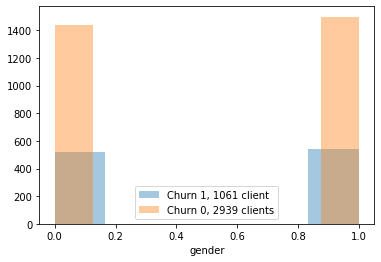

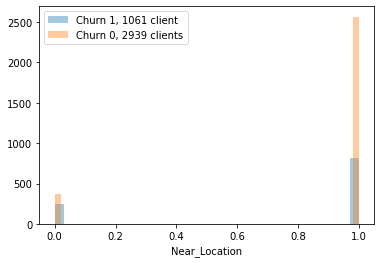

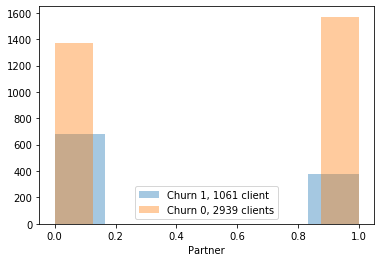

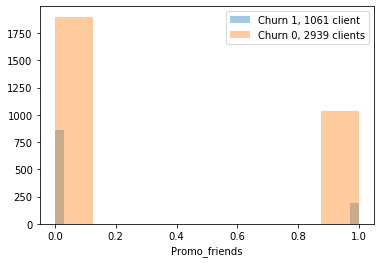

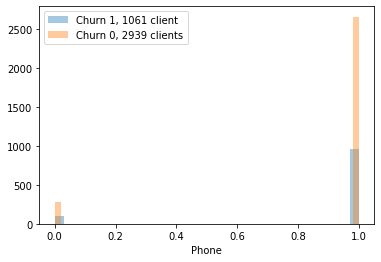

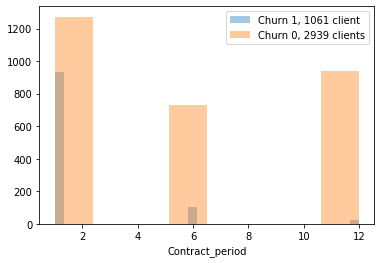

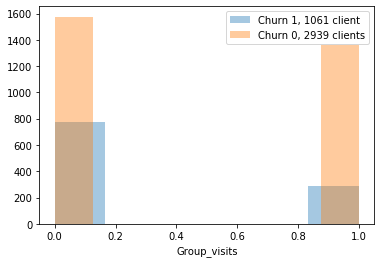

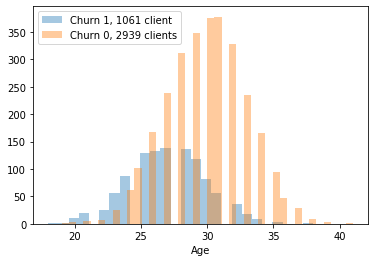

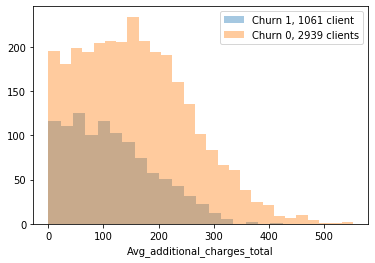

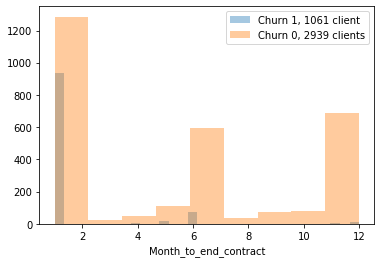

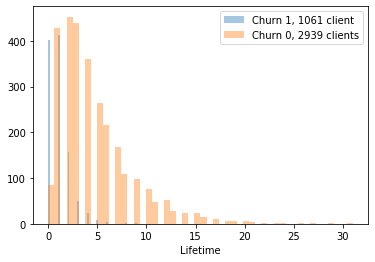

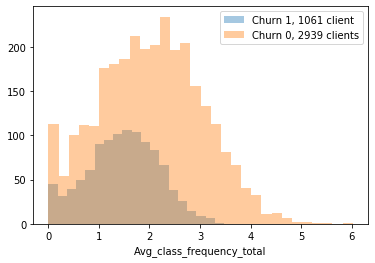

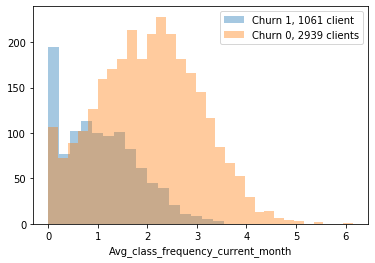

In [14]:
for feature in gym_churn.drop('Churn', axis=1).columns:
    sns.distplot(gym_churn.query('Churn == 1')[feature], kde=False, label='Churn 1, 1061 client')
    sns.distplot(gym_churn.query('Churn == 0')[feature], kde=False, label='Churn 0, 2939 clients')
    plt.legend();
    plt.show()

`Пол`: теперь и на графике видно, распреление клиентов по полу практически равномерно.    
`Близкое расположение`: для клиентов не из группы оттока больше тех, кто живет или работает поблизости.  
`Клиенты партнера`: среди тех, кто в группе оттока большая доля клиентов не по партнерской программе.  
`Телефон`: клиенты оставляют телефон в обеих группах одинаково.  
`Длительность абонемента`: для клиентов оттока основная длительность абонементов -- 1 месяц, совсем немного - 6 месяцев и 3. Среди оставшихся клиентов так же велика доля абонементов 1 месяца, но есть значительная часть 6 и 12.  
`Возраст`: клиенты группы оттока в среднем немного младше, наибольшее число приходится на возраст 27.5, у другой группы -- 30  
`Средние расходы на доп. услуги`: у кгруппы оттока -- до 100 ден единиц, у другой группы -- до 200.  
`Средняя частота посещений в неделю` и `Средняя частота посещений классов`: у группы оттока она ниже.  

### <a id="corr" style="color:black">2.4. матрица корреляций</a>

In [15]:
cm = gym_churn.corr()

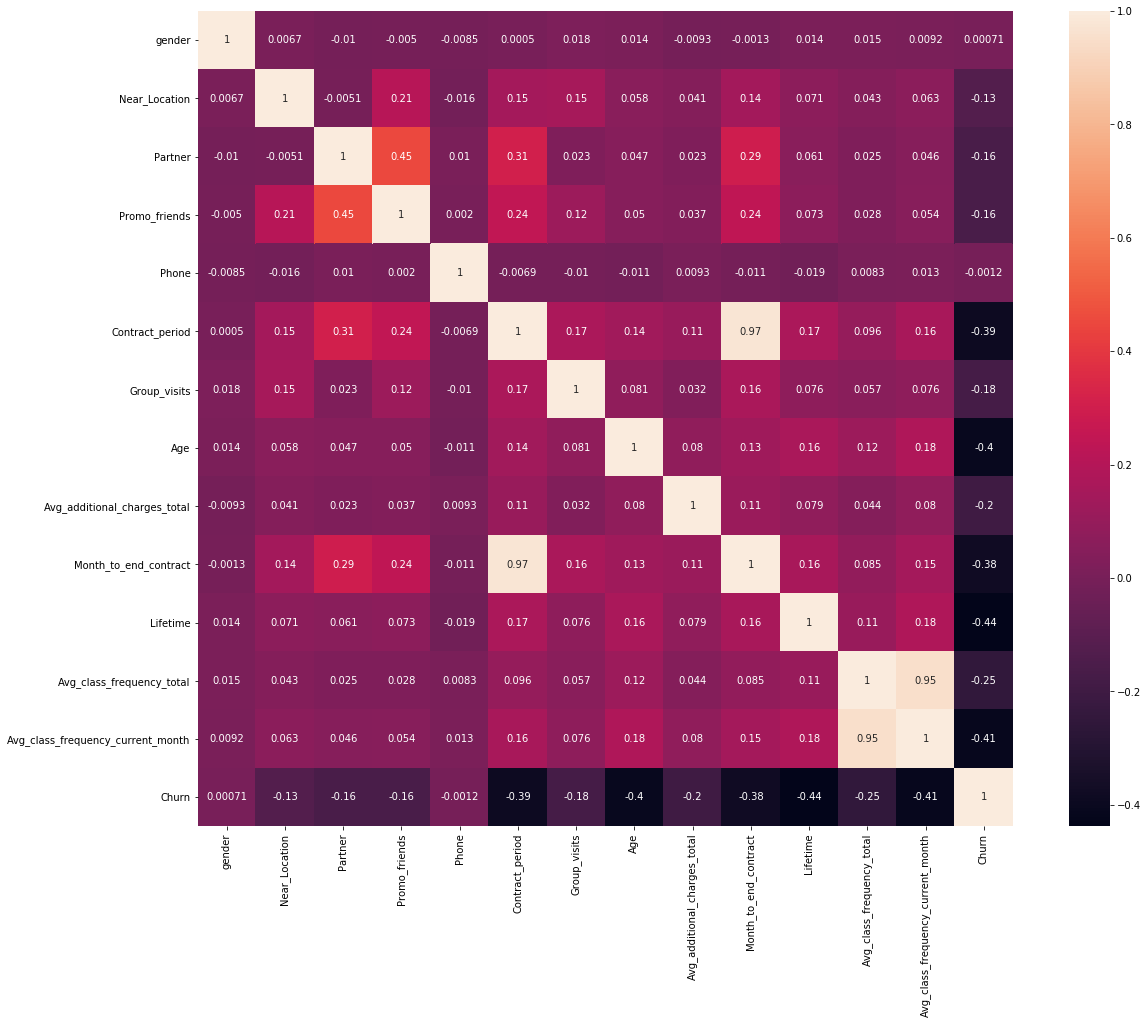

In [16]:
plt.subplots(figsize=(20, 15))
sns.heatmap(cm, annot = True, square=True)

Две пары признаков коррелируют между собой: Contract_period и Month_to_end_contract; Avg_class_frequency_current_month и Avg_class_frequency_total. Поскольку в дальнейшем мы будем пользоваться моделью логистической регрессии (а не Lasso и Ridge), то уберем признаки вручную. Уберем Avg_class_frequency_total (хочется оставить частоту посещений за последний месяц) и Contract_period (хочется знать, сколько месяцев осталось до конца абонемента)

In [17]:
gym_churn = gym_churn.drop('Avg_class_frequency_total', axis=1)
gym_churn = gym_churn.drop('Contract_period', axis=1)


In [18]:
gym_churn.columns

Index(['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Group_visits', 'Age', 'Avg_additional_charges_total',
       'Month_to_end_contract', 'Lifetime',
       'Avg_class_frequency_current_month', 'Churn'],
      dtype='object')

## <a id="churn_model" style="color:black">3. Построение модели прогнозирования оттока пользователей</a>
[к содержанию](#contents)  

### <a id="train_valid" style="color:black">3.1.Разбиение данных на обучающую и валидационную выборки</a>

Представленные данные не имеют привязки ко времени, разделим их рандомно.

In [19]:
X = gym_churn.drop('Churn', axis=1)
y = gym_churn['Churn']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

### <a id="fit" style="color:black">3.2.Обучение модели</a>

Сначала я подумала о том, что юольшинство данных бинарные, а у остальных небольшой разброс, поэтому нет необходимости нормализовать данные. Но на практике получилось такое предупреждение(ниже) "Increase the number of iterations (max_iter) or scale the data..."

In [21]:
model = LogisticRegression()

In [22]:
model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Нормализация

In [23]:
scaler = StandardScaler()

In [24]:
X_train_st = scaler.fit_transform(X_train)

In [25]:
X_test_st = scaler.transform(X_test)

In [26]:
def get_prediction(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print(model)
    print('')
    print('')
    
    df = pd.DataFrame(data={'features': gym_churn.drop('Churn', axis=1).columns,
          'importance': model.coef_[0] if hasattr(model, 'coef_') else model.feature_importances_})
    print(df.sort_values('importance', ascending=False))
    print('')        
    print('Accuracy:{:.2f} Precision:{:.2f} Recall:{:.2f} '.format(accuracy, precision, recall))
    print('')
    print('')


### <a id="metrics" style="color:black">3.3.Оценить метрики accuracy, precision и recall</a>

In [27]:
for model in [LogisticRegression(random_state=0), RandomForestClassifier(random_state=0)]:
    get_prediction(model, X_train_st, X_test_st, y_train, y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


                             features  importance
0                              gender    0.052534
2                             Partner   -0.080828
4                               Phone   -0.087079
1                       Near_Location   -0.089490
3                       Promo_friends   -0.237538
5                        Group_visits   -0.381252
7        Avg_additional_charges_total   -0.581475
6                                 Age   -1.109440
8               Month_to_end_contract   -1.327051
10  Avg_class_frequency_current_month   -1.334673
9                            Lifetime   -3.924250

Accuracy:0.91 Precision:0.80 Recall:0.82 


RandomForestClassifier(bootstr

Доля верно угаданных ответов (Accuracy) у обеих моделей равна. Однако, эту метрику лучше использовать, когда есть баланс классов. У нас в данных был значительный перевес объектов класса 0, возможно, поэтому значение метрики такое высокое, ведь в числителе большое количество верно угаданных объектов класса 0, потому что объектов этого класса и так большое количество.    
Precision говорит, какая доля прогнозов относительно "1" класса верна. Для модели логистической регрессии этот показатель немного меньше, значит при использовании эта модель будет больше ошибаться, выдавать больше "фальшивых" классов 1.  
Recall говорит сколько реальных объектов "1" класса смогли обнаружить. Для модели случайного леса эта метрика меньше, используя ее, есть больший риск пропустить действительный отток.  
В нашем случае предпочтительнее выбрать модель, которая даст меньше пропущенных клиентов оттока, так что выберем логистическую регрессию.

## <a id="clastering" style="color:black">4. Кластеризация пользователей</a>
[к содержанию](#contents)

### <a id="linkage" style="color:black">4.1. Матрица расстояний и дендрограмма</a>

Стандартизируем данные, воспользуемся уже инициализированным инстансом scaler класса StandardScaler: 

In [28]:
gym_churn_st = scaler.fit_transform(gym_churn.drop('Churn', axis=1))

In [29]:
linked = linkage(gym_churn_st, method = 'ward')

In [30]:
dendrogram

<function scipy.cluster.hierarchy.dendrogram(Z, p=30, truncate_mode=None, color_threshold=None, get_leaves=True, orientation='top', labels=None, count_sort=False, distance_sort=False, show_leaf_counts=True, no_plot=False, no_labels=False, leaf_font_size=None, leaf_rotation=None, leaf_label_func=None, show_contracted=False, link_color_func=None, ax=None, above_threshold_color='b')>

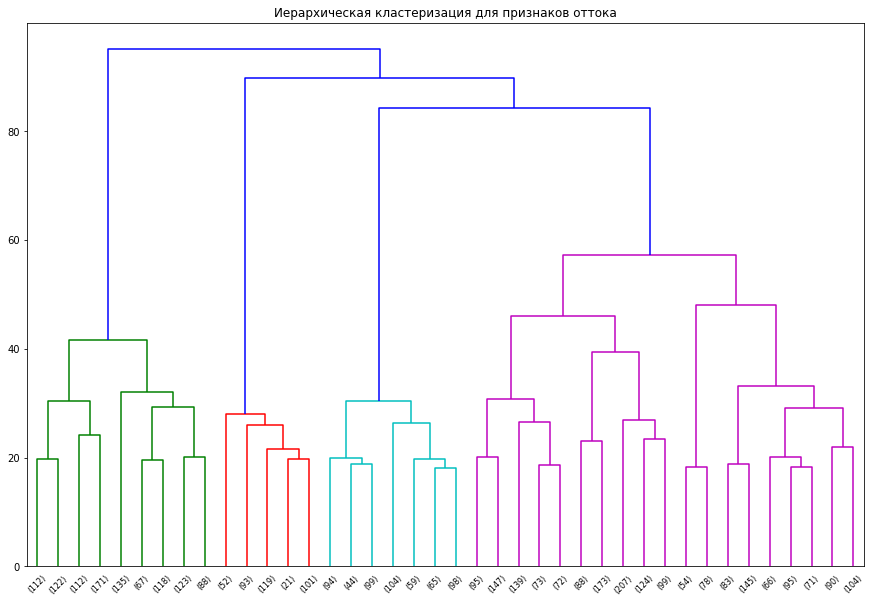

In [31]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, p=40, leaf_rotation=45, truncate_mode='lastp')
plt.title('Иерархическая кластеризация для признаков оттока')
plt.show()

На основании дендрограммы можно выделить 4 большие кластера (если руководствоваться 4мя разными цветами)

### <a id="k_means" style="color:black">4.2. K-Means</a>

In [32]:
km = KMeans(n_clusters=5, random_state=0)


In [33]:
labels = km.fit_predict(gym_churn_st)

In [34]:
gym_churn['clusters'] = labels

Посчитаем, сколько в кадом кластере записей:

In [35]:
gym_churn.groupby('clusters').agg({'gender': 'count'})

,gender
clusters,
0,1044
1,992
2,558
3,386
4,1020


### <a id="clusters_means" style="color:black">4.3. Средние значения признаков кластеров</a>

In [36]:
gym_churn.groupby('clusters').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_current_month,Churn
clusters,,,,,,,,,,,,
0,0.489464,1.000000,0.216475,0.069923,1.0,0.293103,27.557471,115.445899,1.992337,1.905172,1.172300,0.572797
1,0.496976,0.995968,0.886089,1.000000,1.0,0.524194,29.596774,153.707865,6.295363,4.318548,1.921926,0.118952
2,0.500000,0.000000,0.489247,0.078853,1.0,0.232975,28.679211,137.125763,2.818996,2.974910,1.597146,0.403226
3,0.523316,0.862694,0.471503,0.305699,0.0,0.427461,29.297927,144.208179,4.466321,3.940415,1.723967,0.266839
4,0.545098,0.996078,0.379412,0.006863,1.0,0.517647,30.681373,179.010449,5.557843,5.338235,2.334428,0.016667


Можно заметить некоторые отличия кластеров:  
Например, для кластера 2 средняя по признаку близости локации равна 0, значит, это группа тех клиентов, которые живут и работают не подлизости. Кластер 1 -- клиенты по акции приведи друга. Наименьшие средние показатели оттока у кластеров 4(0.02) и 2(0.12), эти же кластеры с наибольшим средним показателем месяцев до окончания абонемента. У кластера 4 наибольший средний показатель трат на дополнительные услуги.

### <a id="clusters_dist" style="color:black">4.4. Распределение признаков кластеров</a>

Для признаков вида 0/1 возьмем countplot

In [37]:
gym_churn.columns


Index(['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Group_visits', 'Age', 'Avg_additional_charges_total',
       'Month_to_end_contract', 'Lifetime',
       'Avg_class_frequency_current_month', 'Churn', 'clusters'],
      dtype='object')

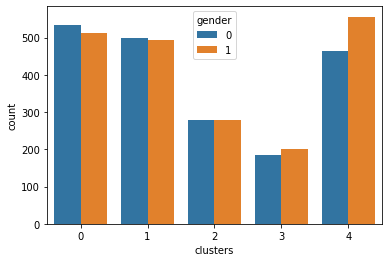

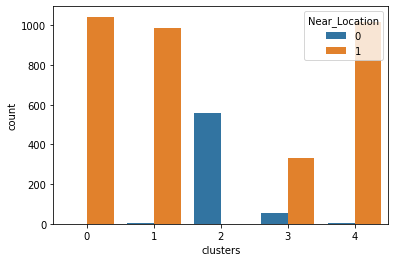

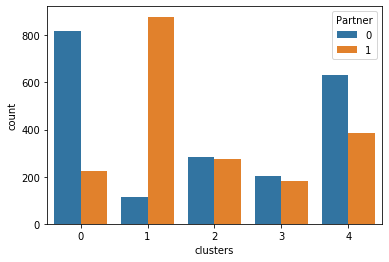

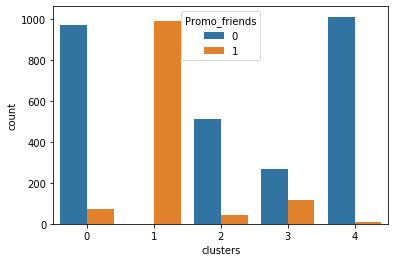

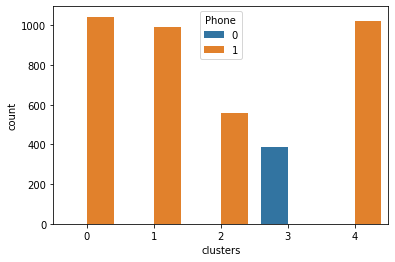

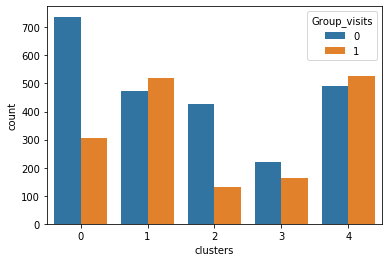

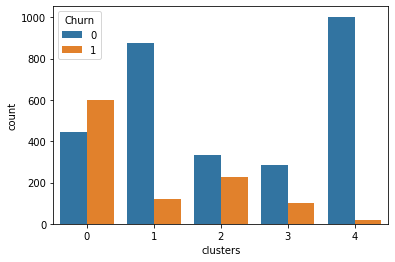

In [38]:
for f in ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Group_visits', 'Churn']:
    sns.countplot(data=gym_churn, x='clusters', hue=f)
    plt.show()

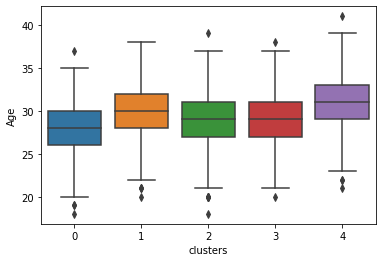

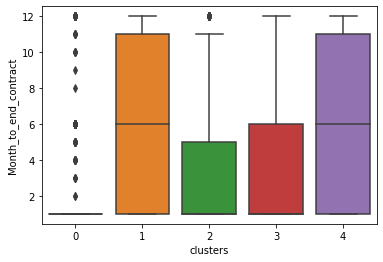

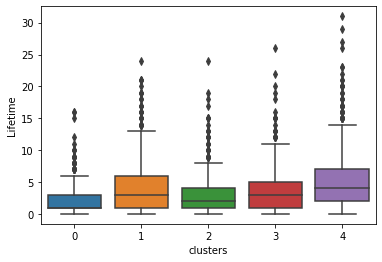

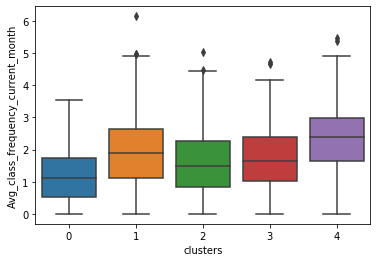

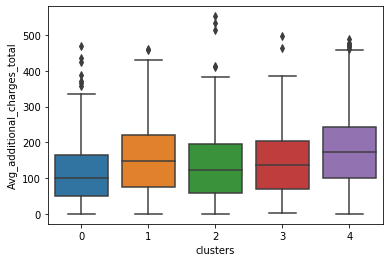

In [39]:
for f in ['Age', 'Month_to_end_contract', 'Lifetime', 'Avg_class_frequency_current_month', 'Avg_additional_charges_total']:
    sns.boxplot(data=gym_churn, x='clusters', y=f)
    plt.show()

`0 кластер`: чуть меньше пол 0, только поблизости, в основном не от партнеров и **не по акции "приведи друга"**,  чуть меньше половины доля посещений групповых занятий. Посещают зал в среднем раз в неделю, средний возраст 27,5, есть "хвост" в возраст меньше 20, **разнообразные варианты до окончания абонемента**, наименьший средний lifetime.  
`1 кластер`: практически равномерное распределение по полу, только поблизости, это почти полностью **клиенты партнеров**, **только по промо акции приведи друга**, групповые занятия посещают 50 на 50, маленький отток. Средний возраст 30, в среднем до конца абонемента 6 мес, lifetime всреднем 2,5 месяца, посещение центра -- 2 раза в неделю.  
`2 кластер`: ровное распределение по полу, эта группа клиентов **не поблизости**, 50/50 клиенты партнеров, не по акции "приведи друга", меньше посещают групповые занятия, доля оттока выше, но не значительно.  
`3 кластер`: чуть больше пол 1, в основном поблизости, **не оставили телефон**, в основном не по приведи друга, не посещают групповые занятия.  
`4 кластер`: больше пол 1, только поблизости, **только не по "приведи друга"**, больше не от партнеров, групповые занятия посещают 50 на 50, минимальный отток. Средний возраст 30, в среднем до конца абонемента 6 мес

1 и 4 кластеры являются наиболее надежными, здесь наименьший отток.

### <a id="churn_rate" style="color:black">4.5. Доля оттока для каждого кластера</a>

In [40]:
clusters_churn = gym_churn.groupby('clusters').agg({'Churn': ['sum', 'count', lambda x: ((x.sum()/x.count())*100).round(2)]})
clusters_churn.columns = ['churn_count', 'all_count', 'churn_rate, %'] 
clusters_churn.sort_values(by='churn_rate, %')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in long_scalars
  """Entry point for launching an IPython kernel.


,churn_count,all_count,"churn_rate, %"
clusters,,,
4,17,1020,1.67
1,118,992,11.90
3,103,386,26.68
2,225,558,40.32
0,598,1044,57.28


## <a id="results" style="color:black">5. Выводы и рекомендации</a>
[к содержанию](#contents)

### Клиенты берут абонемент на месяц чаще всего, среди таких клиентов наибольшая вероятность оттока
Этот признак (Month_to_end_contract) входит в топ значимостей обеих моделей:

Весы признаков модели логистической регрессии (большие положительные значения указывают на важность признака для предсказания "позитивного" класса 1, большие отризательные веса признаков указывают на их важность в предсказании "негативного" класса 0):

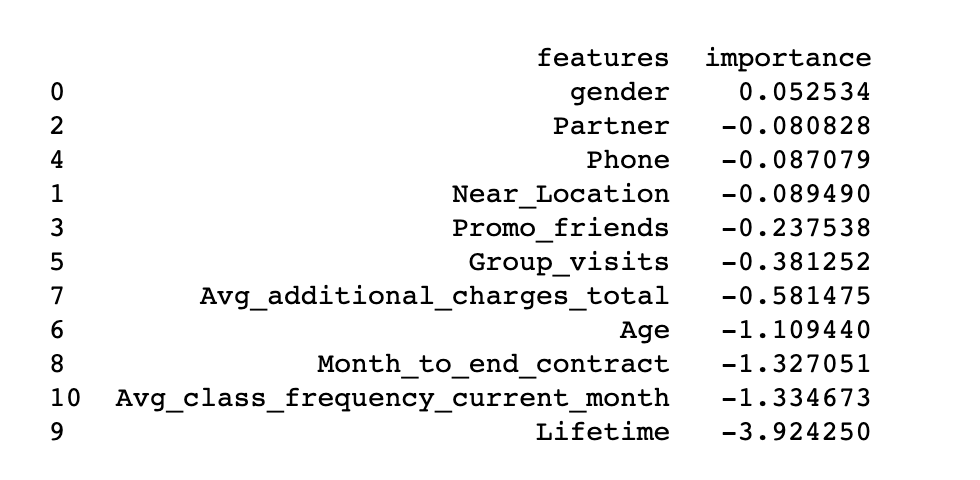

Здесь наиболее важными признаками, влияющими на отток являются Age, Month_to_end_contract, Avg_class_frequency_current_month, Lifetime

Важность признаков модели случайного леса:

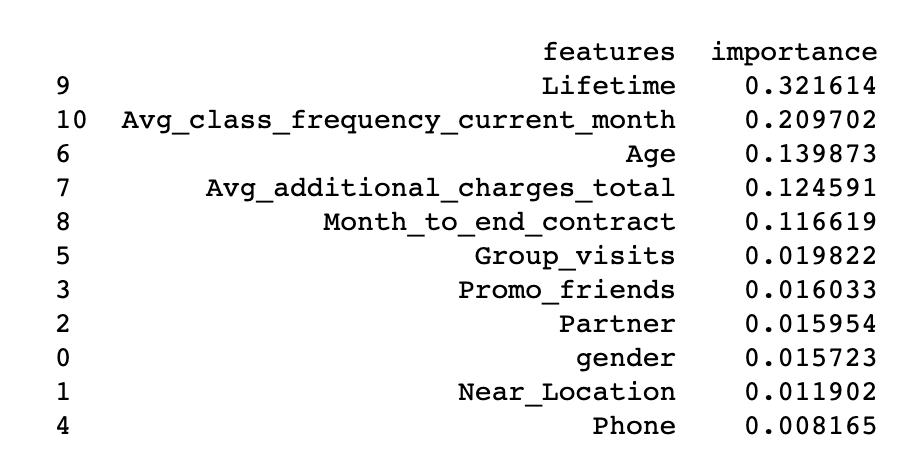

Здесь наиболее важные признаки: Lifetime,  Avg_class_frequency_current_month, Age, Avg_additional_charges_total, Month_to_end_contract

Количество месяцев до конца абонемента:

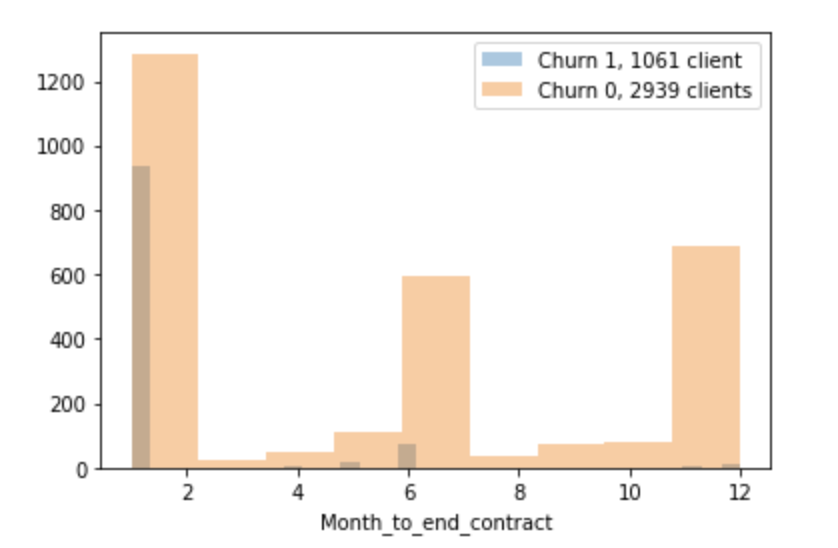

Общая картина: клиенты чаще всего берут абонементы на 1 месяц. Возможно, некоторые просто хотят присмотреться к новому месту или им страшно начинать новую длительную спортивную жизнь. Так же важным признаком является время жизни клиента, конечно, оно связано с продолжительностью абонемента.
Тем не менее было бы здорово организовать получение обратной связи от клиентов, берущих абонемент на 1 месяц, может быть это как-то помогло бы понять причины того, что они не задерживаются.  
Кроме того, возможно компании стоит пересмотреть планы абонементов и добавить абонемент на три месяца -- что-то среднее на пути к полугоду, не будет пугать продолжительностью, но и способствует задержаться подольше.  

### Как часто люди ходят в фитнес-центр

Среди клиентов фитнес-центра есть две выделяющиеся категории, они же меньше всего склонны к уходу. Эти клиенты посещают центр как минимум 2 раза в месяц:

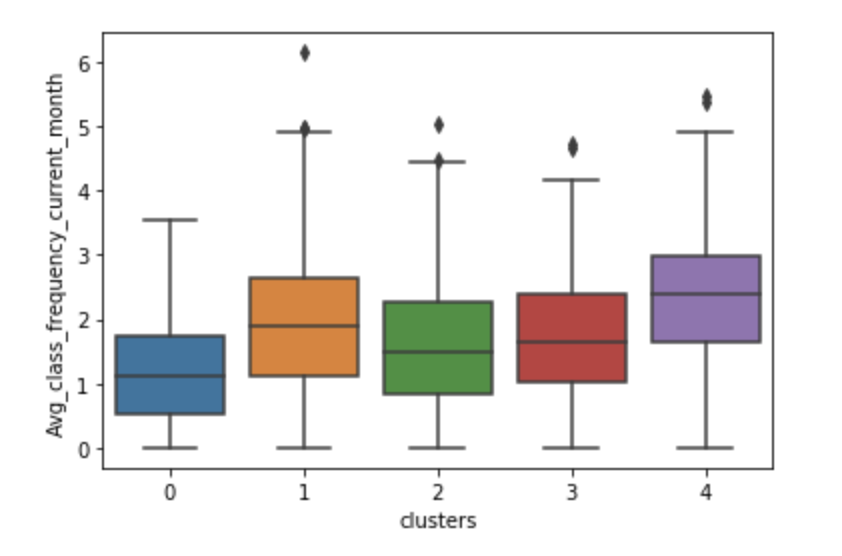

Возможно людям сложно удерживать длинные дистанции в регулярном занятии спортом. Как вариант, чтобы охватить категорию тех, кто долго не задерживается, можно сформировать предложения по переодически проходящим коротким интенсивным программам. Кого-то хватит на короткую дистанцию, и, возможно, через какое-то время захочется повторить еще.